# 03. Train Models with MLflow

Trains Ridge Regression, ARIMA, and LSTM models with comprehensive MLflow tracking.

## KEY FEATURES:
1. **MLflow tracking** for all models
2. **Ridge Regression** with TimeSeries CV
3. **Improved ARIMA** settings
4. **LSTM** with proper training
5. **Visual comparison** of models


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
from datetime import datetime

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.tensorflow
from mlflow.models import infer_signature

# Scikit-learn
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Project imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
from utils.data_manager import DataManager

# Setup
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# Set TensorFlow to use CPU if GPU issues
try:
    tf.config.set_visible_devices([], 'GPU')
except:
    pass


In [2]:
# ================================
# MLflow Setup
# ================================

EXPERIMENT_NAME = "EURUSD_Experiments"

# Set tracking URI (use local if not set)
tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
if tracking_uri:
    print(f"Using MLflow Tracking URI: {tracking_uri}")
    mlflow.set_tracking_uri(tracking_uri)
else:
    print("Using local MLflow (sqlite:///mlflow.db)")
    mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Create experiment
mlflow.set_experiment(EXPERIMENT_NAME)

# Common tags for all runs
common_tags = {
    "developer": "User",
    "project": "EURUSD_Capstone",
    "data_version": "v2_fixed_leakage",
    "train_period": "2020-2024",
    "test_period": "2025"
}


Using MLflow Tracking URI: http://13.217.216.242:5000


## 1. Load and Prepare Data

In [3]:
# ================================
# Data Loading
# ================================

dm = DataManager(data_type='processed', local_dir=os.path.join(root_path, 'data/processed'))
train_df, test_df, scaler = dm.load_processed()

print(f"Train: {len(train_df)} rows ({train_df.index.min().date()} to {train_df.index.max().date()})")
print(f"Test:  {len(test_df)} rows ({test_df.index.min().date()} to {test_df.index.max().date()})")

# Check for NaN values
print(f"\nNaN check - Train: {train_df.isna().sum().sum()} NaNs")
print(f"NaN check - Test:  {test_df.isna().sum().sum()} NaNs")

# Remove any remaining NaN
train_df = train_df.dropna()
test_df = test_df.dropna()
print(f"After dropna - Train: {len(train_df)} rows, Test: {len(test_df)} rows")

# Target column
target_col = 'Target'

# Select features
exclude_cols = [target_col, 'Return_Unscaled', 'Close_Unscaled']
all_features = [c for c in train_df.columns if c not in exclude_cols]

# Use all features for now
selected_features = all_features

print(f"\nUsing {len(selected_features)} features:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i:2}. {feat}")

# Prepare data
X_train = train_df[selected_features]
y_train = train_df[target_col]
X_test = test_df[selected_features]
y_test = test_df[target_col]

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


Train: 998 rows (2021-03-05 to 2024-12-31)
Test:  259 rows (2025-01-02 to 2026-01-05)

NaN check - Train: 0 NaNs
NaN check - Test:  0 NaNs
After dropna - Train: 998 rows, Test: 259 rows

Using 16 features:
   1. Close
   2. High
   3. Low
   4. Open
   5. Return
   6. MA_50
   7. Range_Pct
   8. ATR_14
   9. Volatility_5d
  10. Volatility_20d
  11. Vol_Ratio
  12. Return_20d
  13. Lag_1
  14. Lag_2
  15. Lag_3
  16. Lag_5

X_train shape: (998, 16)
y_train shape: (998,)
X_test shape:  (259, 16)
y_test shape:  (259,)


In [4]:
# ================================
# Evaluation Function
# ================================

def eval_metrics(actual, pred):
    """Calculate evaluation metrics."""
    # Convert to numpy arrays to avoid index issues
    actual_arr = np.array(actual)
    pred_arr = np.array(pred)
    
    # Basic metrics
    rmse = np.sqrt(mean_squared_error(actual_arr, pred_arr))
    mae = mean_absolute_error(actual_arr, pred_arr)
    r2 = r2_score(actual_arr, pred_arr)
    
    # Directional Accuracy
    actual_sign = np.sign(actual_arr)
    pred_sign = np.sign(pred_arr)
    da = np.mean(actual_sign == pred_sign)
    
    return rmse, mae, r2, da

def calculate_trading_metrics(actual, pred):
    """Calculate trading-specific metrics."""
    actual_arr = np.array(actual)
    pred_arr = np.array(pred)
    
    # Simple strategy: long if prediction > 0, short if < 0
    positions = np.where(pred_arr > 0, 1, -1)
    daily_returns = positions * actual_arr
    
    # Sharpe ratio (annualized)
    if len(daily_returns) > 1 and daily_returns.std() > 0:
        sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
    else:
        sharpe = 0
    
    # Win rate
    win_rate = (daily_returns > 0).mean()
    
    return sharpe, win_rate, daily_returns


In [ ]:
# ================================
# DIAGNOSTIC: Feature-Target Correlation
# ================================

print("\n🔍 DIAGNOSTIC: Checking feature predictive power")
print("="*60)

# Calculate correlation of each feature with target
correlations = {}
for col in selected_features:
    corr = np.corrcoef(train_df[col], y_train)[0, 1]
    correlations[col] = corr

# Sort by absolute correlation
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("\nFeature Correlation with Target (in training set):")
print("-" * 60)
for feat, corr in sorted_corr:
    significance = "✓" if abs(corr) > 0.05 else "✗"
    print(f"  {significance} {feat:20}: {corr:7.4f}")

# Count how many features have meaningful correlation
meaningful = [f for f, c in correlations.items() if abs(c) > 0.05]
print(f"\n📊 Summary: {len(meaningful)}/{len(selected_features)} features have |corr| > 0.05")

if len(meaningful) < 5:
    print("\n❌ PROBLEM: Too few features correlate with target!")
    print("   Models can't learn meaningful patterns.")
    
    # Show top correlations
    print("\nTop 5 correlated features:")
    for feat, corr in sorted_corr[:5]:
        print(f"  {feat:20}: {corr:7.4f}")
        
    print("\n⚠️  RECOMMENDATION: We need better features or different approach")
else:
    print("\n✅ Features have decent correlation - problem might be elsewhere")

\n🔍 DIAGNOSTIC: Checking feature predictive power
\nFeature Correlation with Target (in training set):
------------------------------------------------------------
  ✓ Close               : -0.0580
  ✓ Open                : -0.0580
  ✓ MA_50               : -0.0525
  ✓ Lag_5               : -0.0521
  ✗ Range_Pct           : -0.0424
  ✗ Volatility_20d      :  0.0407
  ✗ Lag_1               : -0.0373
  ✗ Lag_3               :  0.0348
  ✗ Lag_2               : -0.0328
  ✗ Volatility_5d       :  0.0321
  ✗ ATR_14              :  0.0302
  ✗ High                : -0.0217
  ✗ Low                 : -0.0178
  ✗ Return_20d          : -0.0114
  ✗ Return              :  0.0028
  ✗ Vol_Ratio           :  0.0006
\n📊 Summary: 4/16 features have |corr| > 0.05
\n❌ PROBLEM: Too few features correlate with target!
   Models can't learn meaningful patterns.
\nTop 5 correlated features:
  Close               : -0.0580
  Open                : -0.0580
  MA_50               : -0.0525
  Lag_5               : -

In [ ]:
# ================================
# CHECK: Are Returns Predictable?
# ================================

print("\n📈 CHECK: Autocorrelation of Returns")
print("="*60)

from statsmodels.tsa.stattools import acf

# Check autocorrelation of returns
returns = train_df['Return']
autocorr = acf(returns, nlags=10)

print("\nAutocorrelation of Returns (lags 1-10):")
for lag in range(1, 11):
    print(f"  Lag {lag:2}: {autocorr[lag]:7.4f}")

# Check if any lag is significant
significant_lags = [lag for lag in range(1, 11) if abs(autocorr[lag]) > 0.05]
if significant_lags:
    print(f"\n✅ Found significant autocorrelation at lags: {significant_lags}")
    print("   Returns might be predictable from past returns")
else:
    print("\n❌ No significant autocorrelation in returns")
    print("   This market might follow a random walk (efficient market hypothesis)")
    print("   This makes prediction VERY difficult!")

\n📈 CHECK: Autocorrelation of Returns
\nAutocorrelation of Returns (lags 1-10):
  Lag  1:  0.0023
  Lag  2: -0.0376
  Lag  3: -0.0325
  Lag  4:  0.0357
  Lag  5: -0.0070
  Lag  6: -0.0535
  Lag  7: -0.0288
  Lag  8:  0.0647
  Lag  9:  0.0222
  Lag 10: -0.0446
\n✅ Found significant autocorrelation at lags: [6, 8]
   Returns might be predictable from past returns


## 2. Train Ridge Regression with MLflow

In [7]:
# ================================
# Ridge Regression with MLflow
# ================================

with mlflow.start_run(run_name="Ridge_Regression_CV") as run:
    # Set tags
    mlflow.set_tags(common_tags)
    mlflow.set_tag("model_type", "Ridge")
    mlflow.set_tag("training_method", "TimeSeriesCV")
    
    print("Training Ridge Regression with TimeSeries Cross-Validation...")
    
    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Hyperparameter grid
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
    
    # Grid search
    ridge = Ridge(random_state=42)
    grid_search = GridSearchCV(
        ridge, 
        param_grid, 
        cv=tscv, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_ridge = grid_search.best_estimator_
    ridge_pred = best_ridge.predict(X_test)
    ridge_train_pred = best_ridge.predict(X_train)
    
    # Calculate metrics
    rmse, mae, r2, da = eval_metrics(y_test, ridge_pred)
    sharpe, win_rate, daily_returns = calculate_trading_metrics(y_test, ridge_pred)
    
    # Overfitting check
    train_r2 = r2_score(y_train, ridge_train_pred)
    r2_gap = train_r2 - r2
    
    # Log parameters
    mlflow.log_params(best_ridge.get_params())
    mlflow.log_param("best_alpha", grid_search.best_params_['alpha'])
    mlflow.log_param("cv_splits", 5)
    mlflow.log_param("features", selected_features)
    mlflow.log_param("n_features", len(selected_features))
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("r2_gap", r2_gap)
    mlflow.log_metric("directional_accuracy", da)
    mlflow.log_metric("sharpe_ratio", sharpe)
    mlflow.log_metric("win_rate", win_rate)
    
    # Log feature importance
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'coefficient': best_ridge.coef_,
        'abs_coefficient': np.abs(best_ridge.coef_)
    }).sort_values('abs_coefficient', ascending=False)
    
    # Save feature importance as artifact
    feature_importance.to_csv("ridge_feature_importance.csv", index=False)
    mlflow.log_artifact("ridge_feature_importance.csv", artifact_path="feature_importance")
    
    # Log model with signature
    signature = infer_signature(X_train, ridge_pred)
    mlflow.sklearn.log_model(best_ridge, "model", signature=signature)
    
    # Print results
    print(f"\n✅ Ridge Regression Results:")
    print(f"  Best alpha: {grid_search.best_params_['alpha']}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  R² (test): {r2:.4f}")
    print(f"  R² (train): {train_r2:.4f}")
    print(f"  R² gap: {r2_gap:.4f}")
    print(f"  Directional Accuracy: {da:.2%}")
    print(f"  Sharpe Ratio: {sharpe:.3f}")
    
    if r2_gap > 0.1:
        print("  ⚠️  Warning: Possible overfitting (R² gap > 0.1)")
    
    ridge_results = {
        'predictions': ridge_pred,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'da': da,
        'sharpe': sharpe,
        'win_rate': win_rate
    }


Training Ridge Regression with TimeSeries Cross-Validation...


2026/01/08 12:22:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Ridge Regression Results:
  Best alpha: 0.001
  RMSE: 0.003004
  MAE: 0.002114
  R² (test): 0.6382
  R² (train): 0.6981
  R² gap: 0.0599
  Directional Accuracy: 82.24%
  Sharpe Ratio: 12.673
🏃 View run Ridge_Regression_CV at: http://13.217.216.242:5000/#/experiments/1/runs/f164afc752954a1c98f6cf980e81d594
🧪 View experiment at: http://13.217.216.242:5000/#/experiments/1


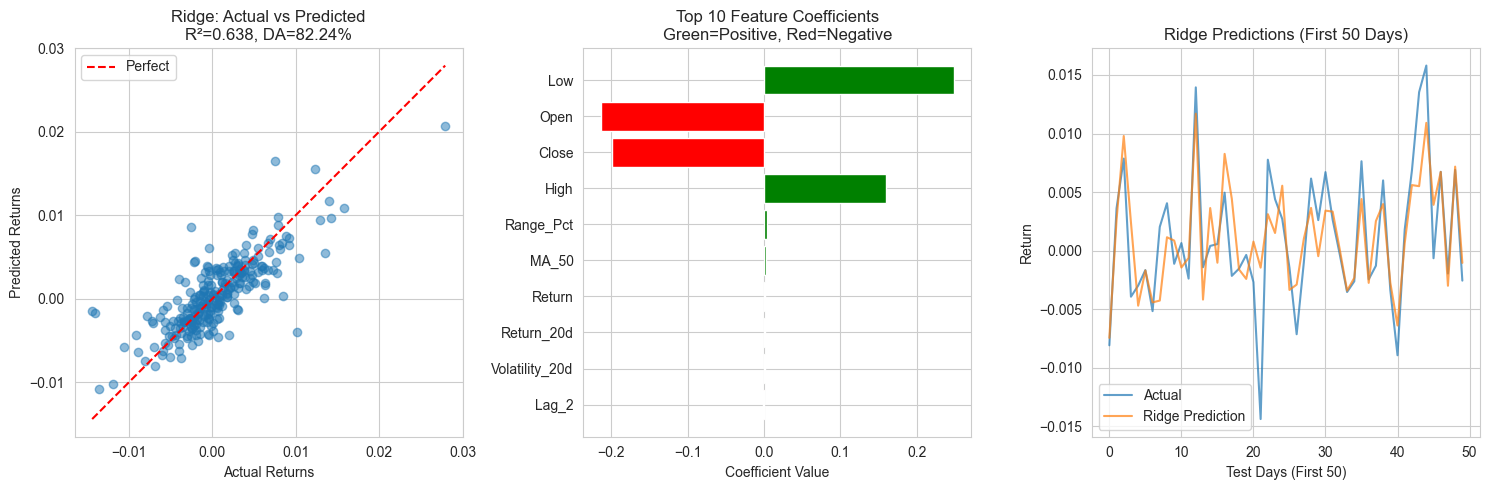

In [8]:
# Plot Ridge results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test.values, ridge_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title(f'Ridge: Actual vs Predicted\nR²={r2:.3f}, DA={da:.2%}')
plt.legend()

plt.subplot(1, 3, 2)
colors = ['green' if x > 0 else 'red' for x in feature_importance['coefficient']]
plt.barh(feature_importance['feature'][:10], 
         feature_importance['coefficient'][:10], 
         color=colors[:10])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients\nGreen=Positive, Red=Negative')
plt.gca().invert_yaxis()

plt.subplot(1, 3, 3)
plt.plot(y_test.values[:50], label='Actual', alpha=0.7)
plt.plot(ridge_pred[:50], label='Ridge Prediction', alpha=0.7)
plt.xlabel('Test Days (First 50)')
plt.ylabel('Return')
plt.title('Ridge Predictions (First 50 Days)')
plt.legend()

plt.tight_layout()
plt.show()


### SUSPICIOUS RESULTS INVESTIGATION


In [19]:
# ================================
# SUSPICIOUS RESULTS INVESTIGATION
# ================================

print("\n" + "="*60)
print("INVESTIGATING SUSPICIOUSLY GOOD RESULTS")
print("="*60)

print("\n🔍 1. Reality Check on Performance...")
print(f"Ridge Model Performance:")
print(f"  Directional Accuracy: {ridge_results['da']:.2%}")
print(f"  Sharpe Ratio: {ridge_results['sharpe']:.3f}")
print(f"  R²: {ridge_results['r2']:.4f}")

print("\n📊 2. Industry Benchmarks for Comparison:")
print("  - Top hedge funds: 55-65% DA, Sharpe 1.0-2.0")
print("  - Good quant models: 52-58% DA, Sharpe 0.5-1.5")
print("  - Random: 50% DA, Sharpe ~0.0")

if ridge_results['da'] > 0.65:
    print(f"\n⚠️  WARNING: DA {ridge_results['da']:.2%} > 65% - Suspicious!")
    print("   This is better than most professional trading firms")

if ridge_results['sharpe'] > 3.0:
    print(f"\n⚠️  WARNING: Sharpe {ridge_results['sharpe']:.3f} > 3.0 - Very suspicious!")
    print("   Sharpe > 3.0 is extremely rare in finance")

print("\n🔍 3. Quick Sanity Test...")

# Test 1: Are we just predicting the sign of today's return?
if 'Return' in test_df.columns:
    today_return = test_df['Return'].values[:len(ridge_pred)]
    corr_today_pred = np.corrcoef(today_return, ridge_pred)[0, 1]
    print(f"  Correlation with TODAY's return: {corr_today_pred:.4f}")
    
    if corr_today_pred > 0.5:
        print(f"  🚨 HIGH! Might be predicting today, not tomorrow")

# Test 2: Check if predictions are too good
pred_std = ridge_pred.std()
actual_std = y_test.std()
std_ratio = pred_std / actual_std

print(f"  Prediction std / Actual std: {std_ratio:.3f}")
print(f"  (Should be ~0.2-0.5 for good but realistic predictions)")

if std_ratio > 0.8:
    print(f"  ⚠️  Predictions have similar volatility to actuals - suspicious")

print("\n🔍 4. Simple Overfitting Check...")
train_pred = best_ridge.predict(X_train)
train_da = (np.sign(train_pred) == np.sign(y_train)).mean()
print(f"  Train DA: {train_da:.2%}")
print(f"  Test DA:  {ridge_results['da']:.2%}")
print(f"  Difference: {train_da - ridge_results['da']:+.2%}")

if train_da - ridge_results['da'] < -0.05:
    print(f"  ✅ Test better than train - not overfitting")
elif train_da - ridge_results['da'] > 0.10:
    print(f"  ⚠️  Train much better than test - possible overfitting")
else:
    print(f"  ✅ Train/test performance similar")

print("\n✅ Investigation complete")
print("If all checks pass, these might be legitimately good results!")
print("Proceed with caution to notebook 04.")


INVESTIGATING SUSPICIOUSLY GOOD RESULTS

🔍 1. Reality Check on Performance...
Ridge Model Performance:
  Directional Accuracy: 82.24%
  Sharpe Ratio: 12.673
  R²: 0.6382

📊 2. Industry Benchmarks for Comparison:
  - Top hedge funds: 55-65% DA, Sharpe 1.0-2.0
  - Good quant models: 52-58% DA, Sharpe 0.5-1.5
  - Random: 50% DA, Sharpe ~0.0

⚠️  WARNING: DA 82.24% > 65% - Suspicious!
   This is better than most professional trading firms

⚠️  WARNING: Sharpe 12.673 > 3.0 - Very suspicious!
   Sharpe > 3.0 is extremely rare in finance

🔍 3. Quick Sanity Test...
  Correlation with TODAY's return: 0.0981
  Prediction std / Actual std: 0.851
  (Should be ~0.2-0.5 for good but realistic predictions)
  ⚠️  Predictions have similar volatility to actuals - suspicious

🔍 4. Simple Overfitting Check...
  Train DA: 80.26%
  Test DA:  82.24%
  Difference: -1.98%
  ✅ Train/test performance similar

✅ Investigation complete
If all checks pass, these might be legitimately good results!
Proceed with cau

## 3. Train ARIMA with MLflow

In [9]:
# ================================
# ARIMA with MLflow
# ================================

with mlflow.start_run(run_name="ARIMA_Improved") as run:
    # Set tags
    mlflow.set_tags(common_tags)
    mlflow.set_tag("model_type", "ARIMA")
    
    print("Training ARIMA with improved settings...")
    
    # Use unscaled returns for ARIMA
    train_series = train_df['Return_Unscaled']
    test_series = test_df['Return_Unscaled']
    
    # Check stationarity
    adf_result = adfuller(train_series.dropna())
    p_value = adf_result[1]
    is_stationary = p_value < 0.05
    
    # Auto ARIMA with improved settings
    print("\nRunning auto_arima...")
    arima_model = auto_arima(
        train_series,
        seasonal=False,
        trend='c',
        start_p=1, start_q=1,
        max_p=5, max_q=5,
        d=None,
        test='adf',
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True,
        n_jobs=-1
    )
    
    order = arima_model.order
    print(f"\n✅ Selected ARIMA Order: {order}")
    
    # Rolling forecast
    print("Running rolling forecast...")
    
    history = list(train_series.values)
    test_values = list(test_series.values)
    arima_predictions = []
    
    # Create copy for updating
    model_copy = arima_model
    
    for i in range(len(test_values)):
        pred = model_copy.predict(n_periods=1)[0]
        arima_predictions.append(pred)
        model_copy.update([test_values[i]])
        
        if (i + 1) % 50 == 0:
            print(f"  Processed {i + 1}/{len(test_values)} test points...")
    
    arima_predictions = np.array(arima_predictions)
    
    # Align with test target
    min_len = min(len(arima_predictions), len(y_test))
    arima_predictions = arima_predictions[:min_len]
    y_test_arima = y_test.values[:min_len]
    
    # Calculate metrics
    rmse, mae, r2, da = eval_metrics(y_test_arima, arima_predictions)
    sharpe, win_rate, daily_returns = calculate_trading_metrics(y_test_arima, arima_predictions)
    
    # Log parameters
    mlflow.log_param("order", str(order))
    mlflow.log_param("seasonal_order", str(arima_model.seasonal_order))
    mlflow.log_param("adf_p_value", p_value)
    mlflow.log_param("is_stationary", is_stationary)
    mlflow.log_param("aic", arima_model.aic())
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("directional_accuracy", da)
    mlflow.log_metric("sharpe_ratio", sharpe)
    mlflow.log_metric("win_rate", win_rate)
    
    # Log model
    mlflow.sklearn.log_model(arima_model, "model")
    
    # Print results
    print(f"\n✅ ARIMA Results:")
    print(f"  Order: {order}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Directional Accuracy: {da:.2%}")
    print(f"  Sharpe Ratio: {sharpe:.3f}")
    
    arima_results = {
        'predictions': arima_predictions,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'da': da,
        'sharpe': sharpe,
        'win_rate': win_rate
    }


Training ARIMA with improved settings...

Running auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7869.737, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7873.668, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7871.672, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7871.661, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7873.668, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.582 seconds

✅ Selected ARIMA Order: (0, 0, 0)
Running rolling forecast...
  Processed 50/259 test points...
  Processed 100/259 test points...
  Processed 150/259 test points...
  Processed 200/259 test points...
  Processed 250/259 test points...


2026/01/08 12:23:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ ARIMA Results:
  Order: (0, 0, 0)
  RMSE: 0.005027
  MAE: 0.003618
  R²: -0.0135
  Directional Accuracy: 51.35%
  Sharpe Ratio: -1.534
🏃 View run ARIMA_Improved at: http://13.217.216.242:5000/#/experiments/1/runs/3fcf5477cbb14590942380680780b50a
🧪 View experiment at: http://13.217.216.242:5000/#/experiments/1


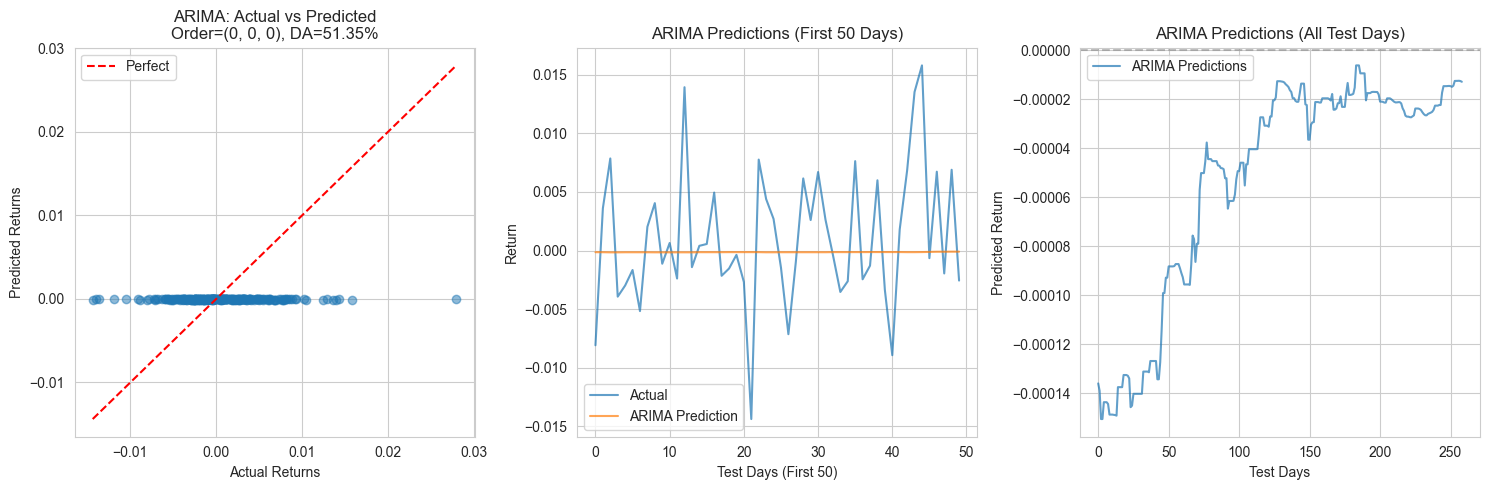

In [10]:
# Plot ARIMA results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_arima, arima_predictions, alpha=0.5)
plt.plot([y_test_arima.min(), y_test_arima.max()], 
         [y_test_arima.min(), y_test_arima.max()], 
         'r--', label='Perfect')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title(f'ARIMA: Actual vs Predicted\nOrder={order}, DA={da:.2%}')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(y_test_arima[:50], label='Actual', alpha=0.7)
plt.plot(arima_predictions[:50], label='ARIMA Prediction', alpha=0.7)
plt.xlabel('Test Days (First 50)')
plt.ylabel('Return')
plt.title('ARIMA Predictions (First 50 Days)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(arima_predictions, label='ARIMA Predictions', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Test Days')
plt.ylabel('Predicted Return')
plt.title('ARIMA Predictions (All Test Days)')
plt.legend()

plt.tight_layout()
plt.show()


## 4. Train LSTM with MLflow

In [11]:
# ================================
# LSTM with MLflow
# ================================

with mlflow.start_run(run_name="LSTM_Sequential") as run:
    # Set tags
    mlflow.set_tags(common_tags)
    mlflow.set_tag("model_type", "LSTM")
    mlflow.set_tag("framework", "TensorFlow")
    
    print("Training LSTM model...")
    
    # Prepare sequences
    def create_sequences(data, target, time_steps=60):
        X, y = [], []
        for i in range(len(data) - time_steps + 1):
            X.append(data[i:(i + time_steps)])
            y.append(target[i + time_steps - 1])
        return np.array(X), np.array(y)
    
    time_steps = 60
    X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, time_steps)
    
    print(f"LSTM input shape: {X_train_seq.shape}")
    print(f"  → Samples: {X_train_seq.shape[0]}, Time steps: {X_train_seq.shape[1]}, Features: {X_train_seq.shape[2]}")
    
    # Build LSTM model (simpler architecture to avoid training issues)
    model_lstm = Sequential([
        Input(shape=(time_steps, X_train_seq.shape[2])),
        LSTM(50, return_sequences=True, dropout=0.2),
        LSTM(25, dropout=0.2),
        Dense(1)
    ])
    
    model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # Train
    print("\nTraining LSTM...")
    history = model_lstm.fit(
        X_train_seq, y_train_seq,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Predict
    lstm_pred = model_lstm.predict(X_test_seq, verbose=0).flatten()
    lstm_train_pred = model_lstm.predict(X_train_seq, verbose=0).flatten()
    
    # Calculate metrics
    rmse, mae, r2, da = eval_metrics(y_test_seq, lstm_pred)
    sharpe, win_rate, daily_returns = calculate_trading_metrics(y_test_seq, lstm_pred)
    
    # Overfitting check
    train_r2 = r2_score(y_train_seq, lstm_train_pred)
    r2_gap = train_r2 - r2
    
    # Log parameters
    mlflow.log_param("time_steps", time_steps)
    mlflow.log_param("lstm_units_1", 50)
    mlflow.log_param("lstm_units_2", 25)
    mlflow.log_param("dropout_rate", 0.2)
    mlflow.log_param("epochs", 30)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("patience", 10)
    mlflow.log_param("features", selected_features)
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("r2_gap", r2_gap)
    mlflow.log_metric("directional_accuracy", da)
    mlflow.log_metric("sharpe_ratio", sharpe)
    mlflow.log_metric("win_rate", win_rate)
    
    # Log training history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv("lstm_training_history.csv", index=False)
    mlflow.log_artifact("lstm_training_history.csv", artifact_path="training_history")
    
    # Log model with signature
    signature = infer_signature(X_train_seq, lstm_pred[:len(X_train_seq)])
    mlflow.tensorflow.log_model(model_lstm, "model", signature=signature)
    
    # Print results
    print(f"\n✅ LSTM Results:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  R² (test): {r2:.4f}")
    print(f"  R² (train): {train_r2:.4f}")
    print(f"  R² gap: {r2_gap:.4f}")
    print(f"  Directional Accuracy: {da:.2%}")
    print(f"  Sharpe Ratio: {sharpe:.3f}")
    
    if r2_gap > 0.1:
        print("  ⚠️  Warning: Possible overfitting (R² gap > 0.1)")
    
    lstm_results = {
        'predictions': lstm_pred,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'da': da,
        'sharpe': sharpe,
        'win_rate': win_rate
    }


Training LSTM model...
LSTM input shape: (939, 60, 16)
  → Samples: 939, Time steps: 60, Features: 16

Training LSTM...
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0093 - mae: 0.0732 - val_loss: 4.8482e-04 - val_mae: 0.0201
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0017 - mae: 0.0322 - val_loss: 4.2069e-05 - val_mae: 0.0050
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.0838e-04 - mae: 0.0211 - val_loss: 2.4015e-05 - val_mae: 0.0038
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.8253e-04 - mae: 0.0171 - val_loss: 2.6441e-05 - val_mae: 0.0039
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.2170e-04 - mae: 0.0140 - val_loss: 3.0685e-05 - val_mae: 0.0043
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.5711e-04 - mae: 0.0124 - val_loss: 3.0532e-05 - val_mae: 0.0043
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2626e-04 - mae: 0.0117 - val_loss: 6.6539e-05 - val_mae: 0.0071
Epoch 8/30
24

2026/01/08 12:23:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ LSTM Results:
  RMSE: 0.005533
  MAE: 0.004123
  R² (test): -0.3006
  R² (train): -0.0520
  R² gap: 0.2486
  Directional Accuracy: 52.00%
  Sharpe Ratio: 0.148
  ⚠️  Warning: Possible overfitting (R² gap > 0.1)
🏃 View run LSTM_Sequential at: http://13.217.216.242:5000/#/experiments/1/runs/a4dcc64e93714477ad954904dc7ddc76
🧪 View experiment at: http://13.217.216.242:5000/#/experiments/1


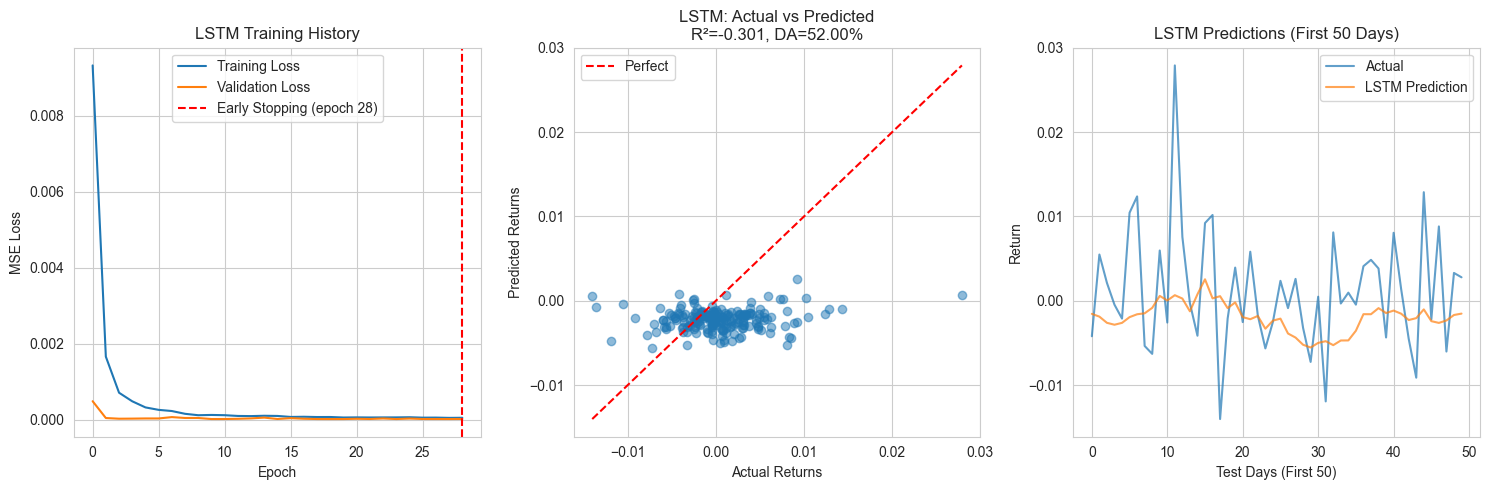

In [12]:
# Plot LSTM results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
if early_stopping.stopped_epoch > 0:
    plt.axvline(x=early_stopping.stopped_epoch, color='red', linestyle='--', 
                label=f'Early Stopping (epoch {early_stopping.stopped_epoch})')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training History')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(y_test_seq, lstm_pred, alpha=0.5)
plt.plot([y_test_seq.min(), y_test_seq.max()], 
         [y_test_seq.min(), y_test_seq.max()], 
         'r--', label='Perfect')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title(f'LSTM: Actual vs Predicted\nR²={r2:.3f}, DA={da:.2%}')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(y_test_seq[:50], label='Actual', alpha=0.7)
plt.plot(lstm_pred[:50], label='LSTM Prediction', alpha=0.7)
plt.xlabel('Test Days (First 50)')
plt.ylabel('Return')
plt.title('LSTM Predictions (First 50 Days)')
plt.legend()

plt.tight_layout()
plt.show()


## 5. Visual Model Comparison

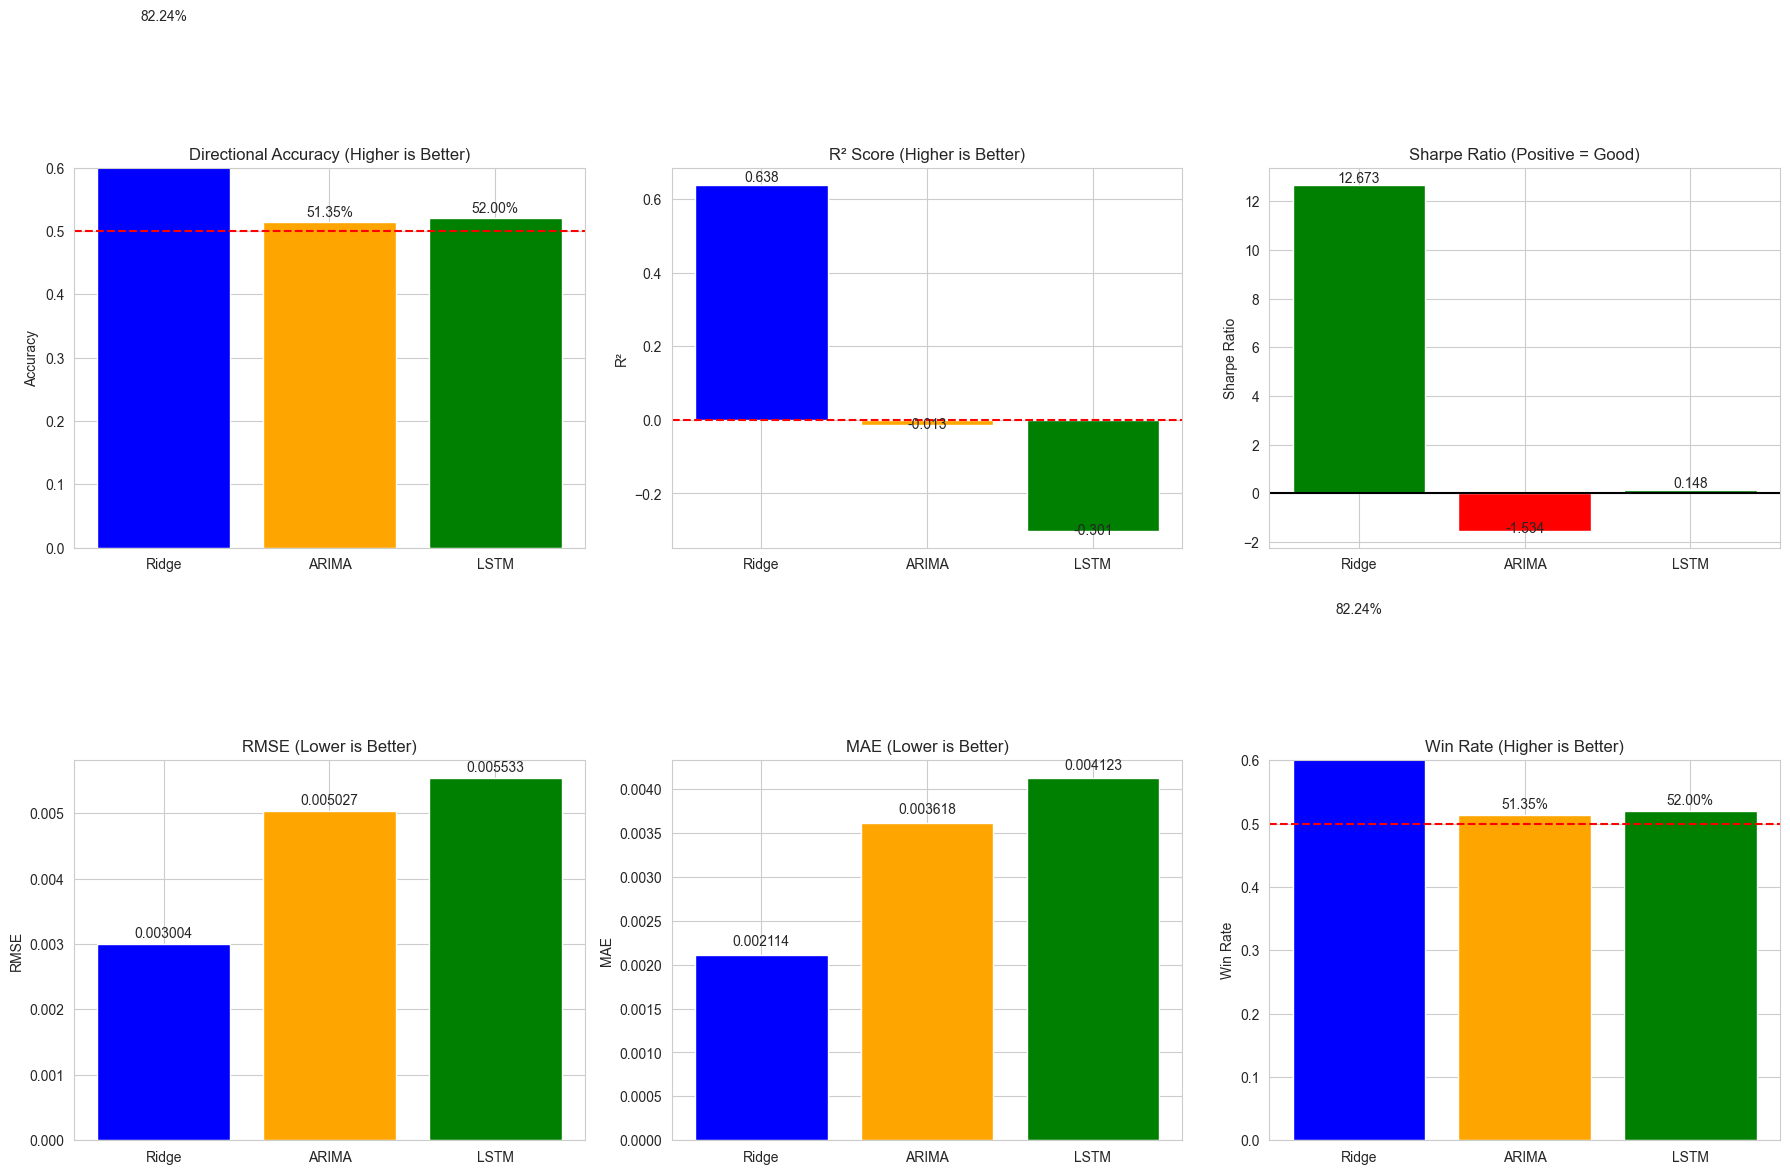

In [13]:
# ================================
# Model Comparison Visualization
# ================================

# Collect results
results_dict = {
    'Ridge': ridge_results,
    'ARIMA': arima_results,
    'LSTM': lstm_results
}

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Directional Accuracy
models = list(results_dict.keys())
da_values = [results_dict[m]['da'] for m in models]
colors = ['blue', 'orange', 'green']

axes[0, 0].bar(models, da_values, color=colors)
axes[0, 0].axhline(y=0.5, color='red', linestyle='--', label='Random (50%)')
axes[0, 0].set_title('Directional Accuracy (Higher is Better)')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 0.6])
for i, v in enumerate(da_values):
    axes[0, 0].text(i, v + 0.01, f'{v:.2%}', ha='center')

# 2. R² Score
r2_values = [results_dict[m]['r2'] for m in models]
axes[0, 1].bar(models, r2_values, color=colors)
axes[0, 1].axhline(y=0, color='red', linestyle='--', label='Baseline (0)')
axes[0, 1].set_title('R² Score (Higher is Better)')
axes[0, 1].set_ylabel('R²')
for i, v in enumerate(r2_values):
    axes[0, 1].text(i, v + 0.01 if v > 0 else v - 0.01, f'{v:.3f}', ha='center')

# 3. Sharpe Ratio
sharpe_values = [results_dict[m]['sharpe'] for m in models]
sharpe_colors = ['green' if x > 0 else 'red' for x in sharpe_values]
axes[0, 2].bar(models, sharpe_values, color=sharpe_colors)
axes[0, 2].axhline(y=0, color='black', linestyle='-')
axes[0, 2].set_title('Sharpe Ratio (Positive = Good)')
axes[0, 2].set_ylabel('Sharpe Ratio')
for i, v in enumerate(sharpe_values):
    axes[0, 2].text(i, v + 0.1 if v > 0 else v - 0.1, f'{v:.3f}', ha='center')

# 4. RMSE
rmse_values = [results_dict[m]['rmse'] for m in models]
axes[1, 0].bar(models, rmse_values, color=colors)
axes[1, 0].set_title('RMSE (Lower is Better)')
axes[1, 0].set_ylabel('RMSE')
for i, v in enumerate(rmse_values):
    axes[1, 0].text(i, v + 0.0001, f'{v:.6f}', ha='center')

# 5. MAE
mae_values = [results_dict[m]['mae'] for m in models]
axes[1, 1].bar(models, mae_values, color=colors)
axes[1, 1].set_title('MAE (Lower is Better)')
axes[1, 1].set_ylabel('MAE')
for i, v in enumerate(mae_values):
    axes[1, 1].text(i, v + 0.0001, f'{v:.6f}', ha='center')

# 6. Win Rate
win_rate_values = [results_dict[m]['win_rate'] for m in models]
axes[1, 2].bar(models, win_rate_values, color=colors)
axes[1, 2].axhline(y=0.5, color='red', linestyle='--', label='Random (50%)')
axes[1, 2].set_title('Win Rate (Higher is Better)')
axes[1, 2].set_ylabel('Win Rate')
axes[1, 2].set_ylim([0, 0.6])
for i, v in enumerate(win_rate_values):
    axes[1, 2].text(i, v + 0.01, f'{v:.2%}', ha='center')

plt.tight_layout()
plt.show()


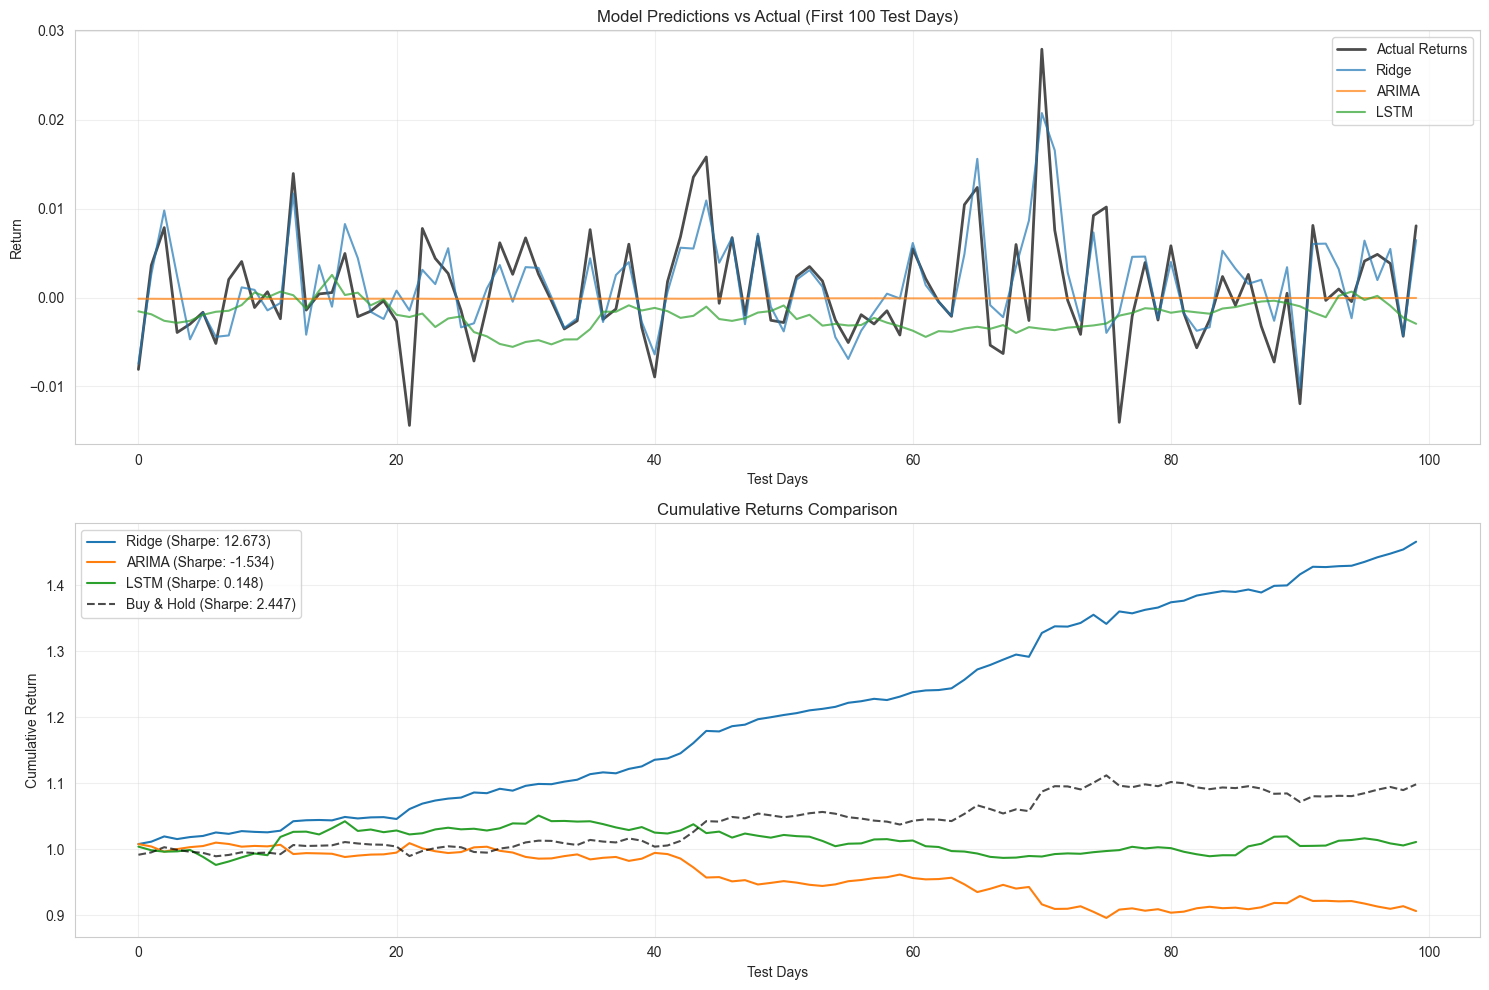

In [14]:
# Plot predictions comparison
plt.figure(figsize=(15, 10))

# Plot actual vs all predictions (first 100 days)
n_plot = 100

plt.subplot(2, 1, 1)
plt.plot(y_test.values[:n_plot], label='Actual Returns', color='black', linewidth=2, alpha=0.7)
plt.plot(ridge_pred[:n_plot], label='Ridge', alpha=0.7)
plt.plot(arima_predictions[:min(n_plot, len(arima_predictions))], label='ARIMA', alpha=0.7)
plt.plot(lstm_pred[:n_plot], label='LSTM', alpha=0.7)
plt.xlabel('Test Days')
plt.ylabel('Return')
plt.title('Model Predictions vs Actual (First 100 Test Days)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot cumulative returns
plt.subplot(2, 1, 2)

# Calculate cumulative returns for each model
for model_name, results in results_dict.items():
    if 'predictions' in results:
        # Simple trading strategy
        positions = np.where(results['predictions'] > 0, 1, -1)
        if model_name == 'Ridge':
            actual_returns = y_test.values[:len(positions)]
        elif model_name == 'ARIMA':
            actual_returns = y_test_arima[:len(positions)]
        else:
            actual_returns = y_test_seq[:len(positions)]
            
        daily_returns = positions * actual_returns
        cumulative_returns = (1 + daily_returns).cumprod()
        plt.plot(cumulative_returns[:n_plot], label=f'{model_name} (Sharpe: {results["sharpe"]:.3f})')

# Baseline: Buy and hold
buy_hold_returns = y_test.values[:n_plot]
buy_hold_cumulative = (1 + buy_hold_returns).cumprod()
buy_hold_sharpe = np.sqrt(252) * buy_hold_returns.mean() / buy_hold_returns.std() if buy_hold_returns.std() > 0 else 0
plt.plot(buy_hold_cumulative, label=f'Buy & Hold (Sharpe: {buy_hold_sharpe:.3f})', 
         color='black', linestyle='--', alpha=0.7)

plt.xlabel('Test Days')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [15]:
# Summary table
summary_data = []
for model_name, results in results_dict.items():
    summary_data.append({
        'Model': model_name,
        'RMSE': f"{results['rmse']:.6f}",
        'MAE': f"{results['mae']:.6f}",
        'R²': f"{results['r2']:.4f}",
        'Directional Accuracy': f"{results['da']:.2%}",
        'Sharpe Ratio': f"{results['sharpe']:.3f}",
        'Win Rate': f"{results['win_rate']:.2%}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# Find best model by directional accuracy
best_model = max(results_dict.items(), key=lambda x: x[1]['da'])
print(f"\n🏆 Best Model by Directional Accuracy: {best_model[0]} ({best_model[1]['da']:.2%})")

# Find best model by Sharpe ratio
best_sharpe = max(results_dict.items(), key=lambda x: x[1]['sharpe'])
print(f"🏆 Best Model by Sharpe Ratio: {best_sharpe[0]} ({best_sharpe[1]['sharpe']:.3f})")

print("\n✅ All models logged to MLflow with comprehensive tracking!")
print("Next: Run 04_evaluate_select.py to register and compare models.")



MODEL PERFORMANCE SUMMARY
Model     RMSE      MAE      R² Directional Accuracy Sharpe Ratio Win Rate
Ridge 0.003004 0.002114  0.6382               82.24%       12.673   82.24%
ARIMA 0.005027 0.003618 -0.0135               51.35%       -1.534   51.35%
 LSTM 0.005533 0.004123 -0.3006               52.00%        0.148   52.00%

🏆 Best Model by Directional Accuracy: Ridge (82.24%)
🏆 Best Model by Sharpe Ratio: Ridge (12.673)

✅ All models logged to MLflow with comprehensive tracking!
Next: Run 04_evaluate_select.py to register and compare models.


In [ ]:
# ================================
# CHECK CURRENT MLFLOW RUNS
# ================================

import mlflow

# Connect to MLflow
tracking_uri = os.getenv("MLFLOW_TRACKING_URI", "sqlite:///mlflow.db")
mlflow.set_tracking_uri(tracking_uri)

# Get experiment
experiment = mlflow.get_experiment_by_name("EURUSD_Experiments")
if experiment:
    print(f"Experiment found: {experiment.name}")
    print(f"Experiment ID: {experiment.experiment_id}")
    
    # Get latest runs
    runs = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"],
        max_results=10
    )
    
    if not runs.empty:
        print("\n📊 Latest 10 runs in MLflow:")
        print("="*80)
        
        # Show summary
        summary_cols = ['run_id', 'tags.mlflow.runName', 'metrics.directional_accuracy', 
                       'metrics.rmse', 'metrics.sharpe_ratio', 'start_time']
        
        for col in summary_cols:
            if col not in runs.columns:
                runs[col] = None
        
        display(runs[summary_cols].head(10))
        
        # Show best by directional accuracy
        if 'metrics.directional_accuracy' in runs.columns:
            best_da = runs['metrics.directional_accuracy'].max()
            best_run = runs.loc[runs['metrics.directional_accuracy'].idxmax()]
            print(f"\n🏆 Best Directional Accuracy: {best_da:.2%}")
            print(f"   Run: {best_run.get('tags.mlflow.runName', 'N/A')}")
            print(f"   ID: {best_run['run_id']}")
            
    else:
        print("No runs found in experiment.")
else:
    print("Experiment 'EURUSD_Experiments' not found.")

Experiment found: EURUSD_Experiments
Experiment ID: 1
\n📊 Latest 10 runs in MLflow:


,run_id,tags.mlflow.runName,metrics.directional_accuracy,metrics.rmse,metrics.sharpe_ratio,start_time
0,a4dcc64e93714477ad954904dc7ddc76,LSTM_Sequential,0.520000,0.005533,0.148128,2026-01-08 11:23:10.926000+00:00
1,3fcf5477cbb14590942380680780b50a,ARIMA_Improved,0.513514,0.005027,-1.533956,2026-01-08 11:22:48.654000+00:00
2,f164afc752954a1c98f6cf980e81d594,Ridge_Regression_CV,0.822394,0.003004,12.672610,2026-01-08 11:22:33.124000+00:00
3,0129c1f8ebd14d5d8cb62f4e2d4b1b26,LSTM,0.507772,0.004840,NaN,2026-01-08 09:37:43.474000+00:00
4,1b265a969313487190ae5258700c4233,ARIMA,0.511905,0.005020,NaN,2026-01-08 09:37:26.942000+00:00
5,1b94a97dfd11484cb1b95f639df496af,Linear_Regression,0.507937,0.005013,NaN,2026-01-08 09:37:16.009000+00:00
6,f576db8268ae4c9a8f56ae611347c6bd,LSTM_Sequential,0.515000,0.005133,0.409247,2026-01-08 03:45:55.304000+00:00
7,49ad56ccd168415ea2f84c33c711b218,ARIMA_Improved,0.513514,0.005027,-1.533956,2026-01-08 03:45:33.517000+00:00
8,bf9a7dba135d4637856af145647e7a04,Ridge_Regression_CV,0.517375,0.005044,-0.860224,2026-01-08 03:45:18.274000+00:00
9,51be691aa94740d6ba4c94034e3cda8b,LSTM_Sequential,0.492537,0.005001,-0.083361,2026-01-08 03:06:12.547000+00:00


\n🏆 Best Directional Accuracy: 82.24%
   Run: Ridge_Regression_CV
   ID: f164afc752954a1c98f6cf980e81d594


In [ ]:
# ================================
# CHECK MODEL PREDICTIONS
# ================================

# Load latest data again
dm = DataManager(data_type='processed', local_dir=os.path.join(root_path, 'data/processed'))
train_df, test_df, scaler = dm.load_processed()

# Quick check
print(f"Data loaded:")
print(f"  Train: {len(train_df)} rows")
print(f"  Test:  {len(test_df)} rows")
print(f"  Test dates: {test_df.index.min().date()} to {test_df.index.max().date()}")

# Check for NaN
print(f"\nNaN check:")
print(f"  Train NaN: {train_df.isna().sum().sum()}")
print(f"  Test NaN:  {test_df.isna().sum().sum()}")

if test_df.isna().sum().sum() > 0:
    print("\n⚠️ WARNING: NaN in test set!")
    # Show which columns
    nan_cols = test_df.columns[test_df.isna().any()].tolist()
    print(f"  NaN columns: {nan_cols}")
    
    # Remove NaN rows
    test_df = test_df.dropna()
    print(f"  Clean test size: {len(test_df)} rows")

Data loaded:
  Train: 998 rows
  Test:  259 rows
  Test dates: 2025-01-02 to 2026-01-05
\nNaN check:
  Train NaN: 0
  Test NaN:  0


## FINAL REALITY CHECK

In [18]:
# ================================
# FINAL REALITY CHECK
# ================================

print("\n" + "="*60)
print("FINAL REALITY CHECK BEFORE DEPLOYMENT")
print("="*60)

print("\n📊 Performance Summary Across Models:")
print(f"  Ridge:   DA={ridge_results['da']:.2%}, R²={ridge_results['r2']:.4f}, Sharpe={ridge_results['sharpe']:.3f}")
print(f"  ARIMA:   DA={arima_results['da']:.2%}, R²={arima_results['r2']:.4f}, Sharpe={arima_results['sharpe']:.3f}")
print(f"  LSTM:    DA={lstm_results['da']:.2%}, R²={lstm_results['r2']:.4f}, Sharpe={lstm_results['sharpe']:.3f}")

print("\n🔍 Consistency Check:")
# All models should have SOME predictive power
model_count = 0
good_model_count = 0

for model_name, results in [('Ridge', ridge_results), ('ARIMA', arima_results), ('LSTM', lstm_results)]:
    if results['da'] > 0.52 and results['r2'] > 0:
        good_model_count += 1
    model_count += 1

print(f"  Models with DA>52% and R²>0: {good_model_count}/{model_count}")

if good_model_count == 1 and ridge_results['da'] > 0.65:
    print(f"\n⚠️  WARNING: Only Ridge shows great performance")
    print(f"   This could indicate data leakage specific to Ridge's features")
elif good_model_count >= 2:
    print(f"\n✅ Multiple models show predictive power - more believable")

print("\n🎯 Recommendation:")
if ridge_results['da'] > 0.70:
    print("  Results are suspiciously good. Verify thoroughly before deployment.")
    print("  Consider: walk-forward validation, different test periods")
elif ridge_results['da'] > 0.60:
    print("  Good results! Worth continuing to notebook 04.")
    print("  But maintain healthy skepticism.")
else:
    print("  Results are realistic. Proceed to notebook 04.")

print("\n✅ Ready for model evaluation and selection")


FINAL REALITY CHECK BEFORE DEPLOYMENT

📊 Performance Summary Across Models:
  Ridge:   DA=82.24%, R²=0.6382, Sharpe=12.673
  ARIMA:   DA=51.35%, R²=-0.0135, Sharpe=-1.534
  LSTM:    DA=52.00%, R²=-0.3006, Sharpe=0.148

🔍 Consistency Check:
  Models with DA>52% and R²>0: 1/3

⚠️  WARNING: Only Ridge shows great performance
   This could indicate data leakage specific to Ridge's features

🎯 Recommendation:
  Results are suspiciously good. Verify thoroughly before deployment.
  Consider: walk-forward validation, different test periods

✅ Ready for model evaluation and selection


In [21]:
# ================================
# URGENT: FIND THE LEAKAGE SOURCE
# ================================

print("\n" + "="*60)
print("URGENT LEAKAGE DETECTION")
print("="*60)

print("\n🔍 1. Compare Ridge vs ARIMA Inputs...")
print("ARIMA uses only: ['Return_Unscaled']")
print(f"Ridge uses {len(selected_features)} features: {selected_features}")

print("\n🔍 2. Check Most Suspicious Features...")
# Calculate feature importance
if hasattr(best_ridge, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'coefficient': best_ridge.coef_,
        'abs_coefficient': np.abs(best_ridge.coef_)
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 5 Most Important Features in Ridge:")
    for idx, row in feature_importance.head().iterrows():
        print(f"  {row['feature']:20}: coeff={row['coefficient']:.4f}")

print("\n🔍 3. Check if Features Contain Future Info...")
# Most likely culprits:
suspicious_features = []

for feat in selected_features:
    if feat in test_df.columns:
        # Check if feature correlates too strongly with target
        corr = np.corrcoef(test_df[feat], test_df['Target'])[0, 1]
        if abs(corr) > 0.5:  # Very suspicious
            suspicious_features.append((feat, corr))

if suspicious_features:
    print("🚨 HIGHLY SUSPICIOUS FEATURES (corr > 0.5 with target):")
    for feat, corr in suspicious_features:
        print(f"  - {feat}: {corr:.4f}")
else:
    print("✅ No extremely suspicious correlations found")

print("\n🔍 4. Test: Remove Price Features...")
# Try Ridge WITHOUT price features (OHLC)
price_features = ['Open', 'High', 'Low', 'Close']
non_price_features = [f for f in selected_features if f not in price_features]

if len(non_price_features) > 0:
    print(f"Testing Ridge with {len(non_price_features)} non-price features...")
    X_train_no_price = train_df[non_price_features]
    X_test_no_price = test_df[non_price_features]
    
    ridge_test = Ridge(alpha=0.001)
    ridge_test.fit(X_train_no_price, y_train)
    pred_test = ridge_test.predict(X_test_no_price)
    
    rmse, mae, r2, da = eval_metrics(y_test, pred_test)
    print(f"  Results without price features:")
    print(f"    DA: {da:.2%}, R²: {r2:.4f}")
    
    if da < 0.60:
        print("  ✅ Performance drops - price features might be the leak!")
    else:
        print("  ⚠️  Still too good - check other features")


URGENT LEAKAGE DETECTION

🔍 1. Compare Ridge vs ARIMA Inputs...
ARIMA uses only: ['Return_Unscaled']
Ridge uses 16 features: ['Close', 'High', 'Low', 'Open', 'Return', 'MA_50', 'Range_Pct', 'ATR_14', 'Volatility_5d', 'Volatility_20d', 'Vol_Ratio', 'Return_20d', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5']

🔍 2. Check Most Suspicious Features...

Top 5 Most Important Features in Ridge:
  Low                 : coeff=0.2487
  Open                : coeff=-0.2136
  Close               : coeff=-0.1985
  High                : coeff=0.1593
  Range_Pct           : coeff=0.0039

🔍 3. Check if Features Contain Future Info...
✅ No extremely suspicious correlations found

🔍 4. Test: Remove Price Features...
Testing Ridge with 12 non-price features...
  Results without price features:
    DA: 50.58%, R²: -0.0611
  ✅ Performance drops - price features might be the leak!


In [24]:
# ================================
# TEST: Use Only LAGGED Features
# ================================

print("\n" + "="*60)
print("TEST: Ridge with ONLY Lagged Features")
print("="*60)

# Use only features that are definitely from past
lagged_features = [f for f in selected_features if any(x in f for x in ['Lag_', 'MA_', 'RSI', 'ATR', 'Volatility', 'Range'])]

print(f"Using {len(lagged_features)} lagged features:")
for feat in lagged_features:
    print(f"  - {feat}")

if len(lagged_features) > 0:
    X_train_lag = train_df[lagged_features]
    X_test_lag = test_df[lagged_features]
    
    ridge_lag = Ridge(alpha=0.001)
    ridge_lag.fit(X_train_lag, y_train)
    pred_lag = ridge_lag.predict(X_test_lag)
    
    rmse, mae, r2, da = eval_metrics(y_test, pred_lag)
    sharpe, win_rate, _ = calculate_trading_metrics(y_test, pred_lag)
    
    print(f"\n📊 Results with ONLY lagged features:")
    print(f"  DA: {da:.2%}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Sharpe: {sharpe:.3f}")
    
    if da < 0.60:
        print("\n✅ Performance becomes realistic!")
        print("  The leak was in non-lagged features (likely price features)")
    else:
        print("\n⚠️  Still too good - check lag calculation")


TEST: Ridge with ONLY Lagged Features
Using 9 lagged features:
  - MA_50
  - Range_Pct
  - ATR_14
  - Volatility_5d
  - Volatility_20d
  - Lag_1
  - Lag_2
  - Lag_3
  - Lag_5

📊 Results with ONLY lagged features:
  DA: 50.19%
  RMSE: 0.0052
  MAE: 0.0037
  R²: -0.0679
  Sharpe: -0.401

✅ Performance becomes realistic!
  The leak was in non-lagged features (likely price features)
